In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())


Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()
import imutils


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Data/Data_Bank/230k.json',
                load_vocabulary = True,
                      image_padding = True,
                      max_width = 700,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )



In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 579 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:



# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s

In [6]:
model = ResNetTransformer(dataset=dataset).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/2560by2560_noresize_collate_lr01.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_recursive.py:262: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

In [11]:
import albumentations
from albumentations.augmentations.geometric.resize import Resize
import torch.nn.functional as F

MAX_RATIO = 12
GOAL_HEIGHT = 64

def find_ratio(h, w, goal):
    return goal/h
    

def predict_new(image_path):
    MAX_RATIO = 12
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ascpect = w/h
    if ascpect == 0:
        ascpect = 1 
    if ascpect > MAX_RATIO:
        ascpect = MAX_RATIO
    
    downscale = GOAL_HEIGHT/h
    image = cv2.resize(image, (0,0), fx=downscale, fy=downscale,interpolation=cv2.INTER_LINEAR)
   
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

def predict(image_path):
    MAX_RATIO = 12
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
    new_h = 45
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    

In [9]:
IMAGES= ['Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png',
         "Jupyter_Notebooks/test_photos/0a0df4c4229b725.png",
         "Jupyter_Notebooks/test_photos/zarhin.png",
         "Jupyter_Notebooks/test_photos/my_image.png",
         "Jupyter_Notebooks/test_photos/screenshot_1.png",
         "Jupyter_Notebooks/test_photos/screenshot_3.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_14.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_10.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_13.png",
          "Jupyter_Notebooks/test_photos/Screen Shot_11.png",
         "Jupyter_Notebooks/test_photos/screenshot_2.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_18.png"
         
    

]

(45, 540, 3)


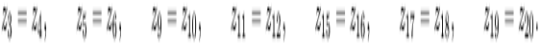

None
torch.Size([1, 45, 540])

Predicted formula:
 <S> \begin{array} { l l l } { b _ { i } } \\ \end{array} \equiv \begin{array} { c } { 0 } & { \qquad \begin{array} { l } { 0 } & { } & { } & { } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } \\ \end{array} = 0 } & { 0 } & { 0 } & { 0 } \\ \end{array} = 0 } & { 0 } & { 0 } & { 0 } \\ \end{array} = 0 } & { 0 } \\ \end{array} = 0 _ { i } \\ \end{array} \begin{array} { i } \\ \end{array} \right. <E> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(45, 195, 3)


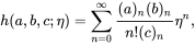

None
torch.Size([1, 45, 195])

Predicted formula:
 <S> h _ { i } ( a , b , c , c , r ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { n } ( b ) _ { n } } { m ( c ) _ { n } } { m ( c ) } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(45, 200, 3)


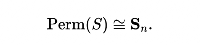

None
torch.Size([1, 45, 200])

Predicted formula:
 <S> \mathrm { ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~


<IPython.core.display.Math object>

None
(45, 170, 3)


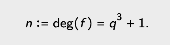

None
torch.Size([1, 45, 170])

Predicted formula:
 <S> \mu : = \mathrm { d e g } q ( f ) : = q ^ { 2 } + q ^ { 3 } + 1 \ . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(45, 194, 3)


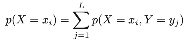

None
torch.Size([1, 45, 194])

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { i = 1 } ^ { i } p ( X = x _ { i } , Y = x _ { i } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(45, 151, 3)


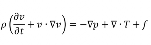

None
torch.Size([1, 45, 151])

Predicted formula:
 <S> \rho \frac { d q } { d w } + \psi _ { N } \psi _ { N } ) = - \psi _ { N } + \psi + \psi <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(45, 320, 3)


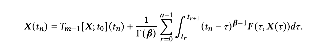

None
torch.Size([1, 45, 320])

Predicted formula:
 <S> \chi ( u ) = \eta _ { m - 1 } ( X _ { n } u ) ( u _ { n } ) - \frac { 1 } { ( T ) } \sum _ { n = 0 } ^ { n } \int _ { n = 0 } ^ { n } f ^ { n + n } ( u _ { n } - \varphi ) d ^ { n - p + p } f ( v ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(45, 466, 3)


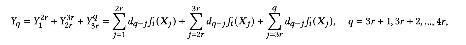

None
torch.Size([1, 45, 466])

Predicted formula:
 <S> V _ { q } \approx \gamma ^ { q } < \gamma _ { q } ^ { q } \otimes \gamma _ { q } ^ { q } = \sum _ { j = 1 } ^ { q } \delta _ { q - j } j _ { q - j } ( X _ { q } ) = \sum _ { j = j } ^ { q } d _ { q - j } j _ { q - j } j _ { q - j } ( X _ { q } ) , \quad q = \infty , n + n + n , n _ { q - k } <E> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(45, 395, 3)


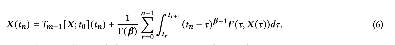

None
torch.Size([1, 45, 395])

Predicted formula:
 <S> \chi ( z _ { 0 } ) = q _ { m } ^ { n - 1 } ( \chi _ { 0 } ) + \frac { 1 } { q ^ { n } } \sum _ { k = 0 } ^ { n } \int _ { k } ^ { n + 1 } ( z _ { 0 } \chi ( \chi ) ) d z . \tag { 0 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(45, 95, 3)


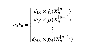

None
torch.Size([1, 45, 95])

Predicted formula:
 <S> < \mathrm { e } \sum _ { \infty } ^ { \frac { \mathrm { S } } { \mathrm { S } } _ { \infty } ^ { \mathrm { S } _ { \infty } ^ { \mathrm { S e } } } { \mathrm { S S } _ { \infty } ^ { \mathrm { S } } = \int _ { \infty } ^ { \infty } { \mathrm { S S } _ { \infty } ^ { \mathrm { S S } } } { \mathrm { S S } _ { \infty } ^ { \mathrm { S } _ { \infty } = 1 } ^ { \infty } } . <E> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(45, 204, 3)


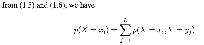

None
torch.Size([1, 45, 204])

Predicted formula:
 <S> \mathrm { a n a n ( 1 ) \omega ( 1 , n , n ) \omega _ { n } } = \sum _ { n = 0 } ^ { n } ( n + n ) \omega _ { n } ^ { n } ( n + n ) \omega _ { n } ^ { n } ( n - n ) \omega _ { n } ^ { n } \omega - \omega _ { n } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(45, 270, 3)


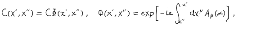

None
torch.Size([1, 45, 270])

Predicted formula:
 <S> G ( \sigma , \omega ) = \xi ( k , \omega ^ { \prime } ) , \quad \Psi ( \omega , \omega ^ { \prime } ) + \omega _ { 2 } ( - \omega ^ { \prime } ) ^ { \prime } \sqrt { \omega ^ { \prime } } \mathrm { e } ^ { \prime } \mathrm { e } ^ { \prime } \mathrm { e } ^ { \prime } ( \omega ) } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [12]:
for image in IMAGES:
    predict(image)